<a href="https://colab.research.google.com/github/ydvdhrj/MakeMore/blob/main/MakeMore2_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making graphs
%matplotlib inline

In [126]:
# read all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [127]:
len(words)

32033

In [128]:
# build the vocabulary of characteres and mapping them from integers
chars = list(sorted(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [129]:
# build the dataset
block_size=3 #context length: how many character we need to predict the next character
def build_dataset(words):
  X,Y = [],[]

  for w in words:
    # print(w)
    context  = [0]*block_size
    for ch in w+'.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '---->', ch)
      context = context[1:] + [ix] #crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])  #80%
Xdev,Ydev = build_dataset(words[n1:n2])  #10%
Xte,Yte = build_dataset(words[n2:])  #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [130]:
len(words)

32033

In [131]:
n1  #training dataset

25626

In [132]:
len(words) - n2  #testing

3204

In [133]:
n2-n1  #dev or validation

3203

In [134]:
# emb @ w1 + b1 -----> this will not work so we have to convert this 32, 3, 2 shape into 32,6 this is like every character of those 3 character contains 2 value

# pytorch provide as cat() function this will contatinate
        # emb[:0:].shape ---> it will be 32,2 similarly all this 3 matrix of 32,2 shape will be concatinate into 32,6 shape
        # syntax of cat is ---> cat(matrix, index along whic u r concatinate)   in our case we concatinate along column i.e  of index 1
# as 3 i.e number of previous character we are usong to predict the next character can be changed so we cant manually put all those indexs
# and to solve this pytorch will have unbind function
# syntax is ---> unbind(provid matrix that wanna unbind, index on which u wanna unbind)

# torch.cat(torch.unbind(emb,1),1).shape

# concatination is actually creating a new tensor which is less memory efficient

# so instead of cat we use view,  view will tell us that in which shape we wanna see the tensor
# tensor is tored as a single dimensional vector in indexes view, stride, metadata help us to get what shape or what tensor we want
# learn more about tensor internals how it s store in database

# syntax of view --->> emb.view(32,6) == emb.view(emb.shape[0],6) == emb.view(-1,6)
# -1 and emb.shape is for general purpose so we dont hard code it
# and when we use -1 pytorch automatically calculate it according to input that what is its dimension

In [135]:
# ---------------Now made respactable -----------

In [136]:
Xtr.shape,Ytr.shape #dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [149]:
# MLP
#we are downgrading w1 and b1 so that hpreact range will be squeezed and it will not lead to dead neurons in tanh activation layer

n_emb = 10 # the dimensionality of the character embedding vectors
n_hidden = 200  #number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size,n_emb),               generator=g)
w1 = torch.randn((n_emb * block_size,n_hidden),   generator=g) * (5/3)/((n_emb * block_size)**0.5) #5/3 is gain for tanh and (n_emb * block_size) is fan_in(or input)    #*0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #we are putting them zero because we want some disceteness in tanh neurons it iss helpfull
w2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# batchNorm parameters
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,w1,w2,b2,bngain,bnbias]
sum(p.nelement() for p in parameters)  #number of parameters in total
for p in parameters:
  p.requires_grad=True

In [138]:
# why we use cross_entropy instead of this
#   counts = logits.exp() # counts, equivalent to N
#   probs = counts/counts.sum(1, keepdims=True) # probabilities for next
#   loss = -probs[torch.arange(num),ys].log().mean()

# because corss_entropy will give us
# 1) optimized forward pass
# 2) optimized backward pass
# 3) things will be more numberically stable

In [150]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(200000):

  # mini batch construct
  ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
  Xb,Yb = Xtr[ix],Ytr[ix] #batch X,Y

  # forward pass
  emb = C[Xb] #emb the characters into vectors
  embcat = emb.view(emb.shape[0],-1) #concatenate the vectors

  # Linear Layer
  hpreact = embcat @ w1 # +b1 #hidden layer preactivation,  this b1 eventually discarded by batchnormalization so it is useless, bnbias is working on its place
  # batchNorm Layer
  # -----------------------------------------------------------------------------------------------------------------------------------------
  bnmeani = hpreact.mean(0,keepdim=True)
  bnstdi = hpreact.std(0,keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias #batch normalisation we add bngain and bnbias so after initialization
  #  during backpropagation our function can modify its value
  # this is inline way of calculating bnmean and bnstd over entire training set
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------------------------------------------------------------------------------------
  # Non-Linearity
  h = torch.tanh(hpreact) #hidden layer
  logits = h @ w2 + b2 #output layer
  loss = F.cross_entropy(logits,Yb) #loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else (0.01 if i < 150000 else 0.0001) #step learning rate decay
  for p in parameters:
    p.data += -lr*p.grad

  # track stats
  if i % 10000 == 0: #print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.1169
 170000/ 200000: 2.4659
 180000/ 200000: 2.0138
 190000/ 200000: 2.1990


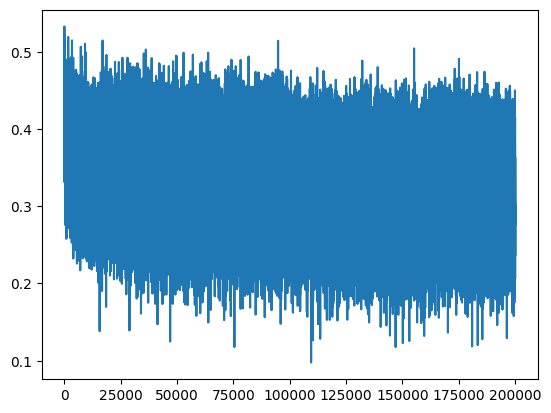

In [151]:
plt.plot(lossi)

In [152]:
# caliberate the batch norm at end of the training
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ w1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0,keepdim=True)
  bnstd = hpreact.std(0,keepdim=True)

In [153]:
@torch.no_grad() #this decorator disable gradient tracking
def split_loss(split):
  x,y = {
    'train':(Xtr,Ytr),
    'val':(Xdev,Ydev),
    'test':(Xte,Yte)
  }[split]
  emb = C[x] #emb the characters into vectors
  embcat = emb.view(emb.shape[0],-1) #concatenate the vectors
  hpreact = embcat @ w1 + b1 #hidden layer preactivation
  # hpreact = bngain * (hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias #batch normalisation we add bngain and bnbias so after initialization
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # it is for inline calculation of bnmean and bnstd
  h = torch.tanh(hpreact) #hidden layer
  logits = h @ w2 + b2 #output layer
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0666167736053467
val 2.1039366722106934


In [154]:
# loss log

# original
# train 2.113111972808838
# val 2.1553359031677246

# first softmax confidently wrong
# train 2.0641093254089355
# val 2.12713360786438

# fix tanh layer too saturated at init
# train 2.031878709793091
# val 2.0978989601135254

# use semi-principled "kaiming init" instead of hacky init:
# train 2.0348522663116455
# val 2.0989720821380615

# after applying batch normalization
# train 2.074030876159668
# val 2.1136670112609863

# in this updation we are not seeing any signifantly change because out nn is of 1 layer but for large nn it works quit well

In [155]:
# for testing
split_loss('test')

test 2.1039631366729736


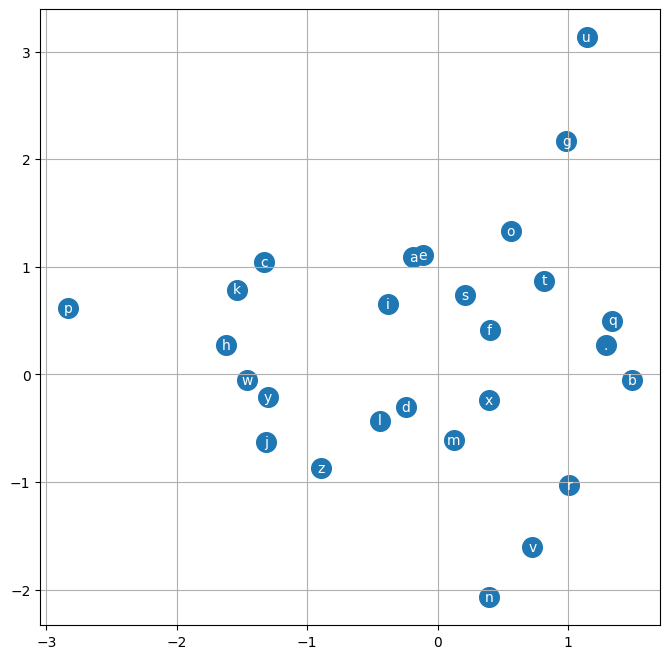

In [156]:
# to visualise when we have 2D embeddings,   it is only good for 2d embedding
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(),C[i,1].item(),itos[i], va='center', ha='center', color='white')
plt.grid('minor')

In [157]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
  out = []
  context = [0]*block_size #initialize with all ...
  while True:
    emb = C[torch.tensor([context])]   #(1,block_size,d)
    h = torch.tanh(emb.view(1,-1) @ w1 + b1)
    logits = h @ w2 +b2
    probs =  F.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1,replacement=True,generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix==0:
      break
  print(''.join(itos[i] for i in out))

cathlif.
trullvifk.
mrithlithl.
kaassierszhntvadghtvicthretif.
qumaritzieiirdgs.
hgy.
shbm.
foctseyghnishlistan.
vabiussttwogdiarisix.
khegzifudhmeddya.
gabgtts.
jaswiyah.
qingtds.
ksyadimbbo.
bosbyc.
jesiahamdrynekp.
sadlviongorgsttlianariahramsklmarraysefennyoqhyld.
bldn.
ffynn.
vaddvi.
